In [39]:
import matplotlib.pyplot as plt
from matplotlib import colors
import mplhep as hep
import scipy
hep.style.use(hep.style.CMS)

import numpy as np
import awkward as ak
import hist as hist2
from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch")


def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_genH(genparticles,candidatefj):
    higgs = getParticles(genparticles,25)
    is_hWW = ak.all(abs(higgs.children.pdgId)==24,axis=2)

    higgs = higgs[is_hWW]
    
    return higgs


class electronReconstructionProcessor(processor.ProcessorABC):
    def __init__(self, jet_arbitration='met', el_wp=None):
        self._jet_arbitration = jet_arbitration
        self.el_wp = el_wp
        
        # output
        self.make_output = lambda: {
            'sumw': 0.,
            'signal_kin': hist2.Hist(
                hist2.axis.Regular(50, 10, 1000, name='genHpt', label=r'gen H $p_T$ [GeV]'),
                hist2.storage.Weight(),
            ),
        }
        
    def process(self, events):
        dataset = events.metadata['dataset']
        selection = PackedSelection()
        weights = Weights(len(events), storeIndividual=True)
        weights.add('genweight', events.genWeight)
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
            
        # leptons
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        lowptmuon = (
            (events.Muon.pt > 10)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.looseId
        )
        nlowptmuons = ak.sum(lowptmuon, axis=1)
        
        if self.el_wp == "wp80":
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WP80)
            )
        elif self.el_wp == "wp90":
             goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WP90)
            )
        elif self.el_wp == "wpl":
             goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
                & (events.Electron.mvaFall17V2noIso_WPL)
            )
        else:
            goodelectron = (
                (events.Electron.pt > 25)
                & (abs(events.Electron.eta) < 2.5)
            )
            
        nelectrons = ak.sum(goodelectron, axis=1)
        lowptelectron = (
            (events.Electron.pt > 10)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.cutBased >= events.Electron.LOOSE)
        )
        nlowptelectrons = ak.sum(lowptelectron, axis=1)
        
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)

        # concatenate leptons and select leading one
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        candidatelep_p4 = ak.zip(
            {
                "pt": candidatelep.pt,
                "eta": candidatelep.eta,
                "phi": candidatelep.phi,
                "mass": candidatelep.mass,
                "charge": candidatelep.charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        # missing transverse energy
        met = events.MET
        
        # jets
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200)
        ]

        dphi_met_fj = abs(candidatefj.delta_phi(met))
        dr_lep_fj = candidatefj.delta_r(candidatelep_p4)
    
        if self._jet_arbitration == 'pt':
            candidatefj = ak.firsts(candidatefj)
        elif self._jet_arbitration == 'met':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        elif self._jet_arbitration == 'lep':
            candidatefj = ak.firsts(candidatefj[ak.argmin(dr_lep_fj,axis=1,keepdims=True)])
        else:
            raise RuntimeError("Unknown candidate jet arbitration")
    
    
        # select only leptons inside the jet
        dr_lep_jet_cut = candidatefj.delta_r(candidatelep_p4) < 0.8
        dr_lep_jet_cut = ak.fill_none(dr_lep_jet_cut, False)
        selection.add("dr_lep_jet", dr_lep_jet_cut)
        
        # gen higgs 
        genhiggs = match_genH(events.GenPart,candidatefj)
        
        # select events with only electrons            
        onelectron = (
            (nelectrons == 1) 
            & (nlowptelectrons <= 1) 
            & (nmuons == 0) 
            & (nlowptmuons == 0) 
            & (ntaus == 0)
        )
        
        # function to normalize arrays after a cut or selection
        def normalize(val, cut=None):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        output['signal_kin'].fill(
            genHpt = normalize(ak.firsts(genhiggs.pt), onelectron),
            weight = weights.weight()[onelectron],
        )
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.42.157:8786' processes=2 threads=4, memory=12.72 GiB>

In [40]:
# baseline 
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=electronReconstructionProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)

In [41]:
# mva80 working point
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

out80 = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=electronReconstructionProcessor(el_wp="wp80"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)

In [43]:
# mva90 working point
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

out90 = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=electronReconstructionProcessor(el_wp="wp90"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)

In [44]:
# loose working point  
fileset = {
    'HWW': ["root://xcache/" + file for file in np.loadtxt("data/hwwdata.txt", dtype=str)]
}

outl = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=electronReconstructionProcessor(el_wp="wpl"),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
        maxchunks=30,
)

In [45]:
den = out["HWW"]["signal_kin"]
num1 = out80["HWW"]["signal_kin"]
num2 = out90["HWW"]["signal_kin"]
num3 = outl["HWW"]["signal_kin"]

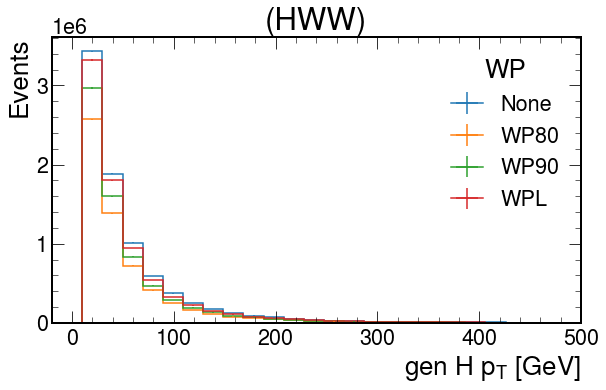

In [53]:
plt.figure(
    figsize=(9,6),
    tight_layout=True,
)

den.plot1d(label="None")
num1.plot1d(label="WP80")
num2.plot1d(label="WP90")
num3.plot1d(label="WPL")

plt.xlim(-20, 500)
plt.ylabel("Events")
plt.title("(HWW)")
plt.legend(title="WP")
plt.gcf().savefig("hww_el_genHpt_wps.png")

In [49]:
def error(num, den):
    return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())

def get_axis(den):
    return [den.axes.value(i)[0] for i in range(len(den.values()))]

/tmp/ipykernel_1454/2640079242.py:2: RuntimeWarning: invalid value encountered in true_divide
  return abs(clopper_pearson_interval(num.values(), den.values()) - num.values()/den.values())
/tmp/ipykernel_1454/3648069543.py:13: RuntimeWarning: invalid value encountered in true_divide
  num1.values()/den.values(),
/tmp/ipykernel_1454/3648069543.py:21: RuntimeWarning: invalid value encountered in true_divide
  num2.values()/den.values(),
/tmp/ipykernel_1454/3648069543.py:29: RuntimeWarning: invalid value encountered in true_divide
  num3.values()/den.values(),


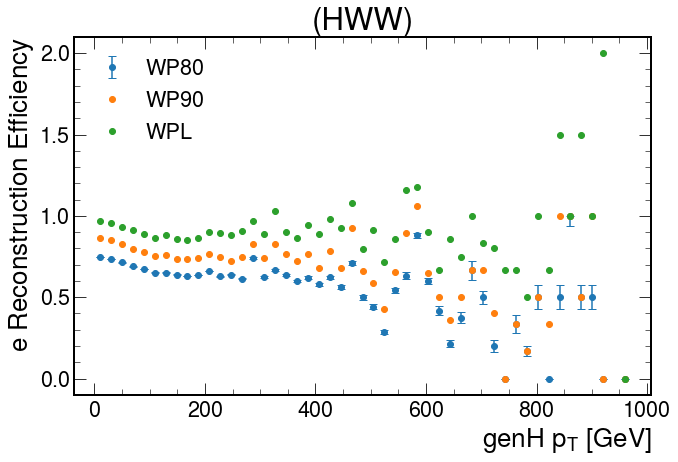

In [50]:
genHpt = get_axis(den)
err1 = error(num1, den)
#err2 = error(num2, den)
#err3 = error(num3, den)

fig, ax = plt.subplots(
    figsize=(10,7),
    tight_layout=True,
)

ax.errorbar(
    genHpt,
    num1.values()/den.values(),
    fmt="o",
    yerr=err1,
    capsize=4,
    label="WP80"
)
ax.errorbar(
    genHpt,
    num2.values()/den.values(),
    fmt="o",
    #yerr=err2,
    capsize=4,
    label="WP90"
)
ax.errorbar(
    genHpt,
    num3.values()/den.values(),
    fmt="o",
    #yerr=err3,
    capsize=4,
    label="WPL"
)
ax.set(
    title="(HWW)",
    xlabel="genH $p_T$ [GeV]",
    ylabel="$e$ Reconstruction Efficiency"
)
ax.legend()
plt.gcf().savefig("hww_elreconstructioneff.png")